In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import numpy as np
import cmocean.cm as ocm
from scipy.interpolate import griddata
from dask.distributed import Client

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data','analysis')
fig_dir  = os.path.join(proj_dir,'reports','devel','figures')
int_dir = os.path.join(data_dir,'interim')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from visualization.shiftedColorMap import shiftedColorMap
from roms_tools.cartesian_grid_2d import cartesian_grid_2d

tools_dir = os.path.join(proj_dir,'src','tools')
sys.path.append(tools_dir)
from rotate_vector_roms import rotate_vector_roms
from make_masks import make_mask_sector,make_mask_shelf_sector,make_mask_ice_shelves

In [3]:
grd_path = os.path.join(int_dir,'grd2_dV.nc')
grd = xr.open_dataset(grd_path)
mask_vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)
grd.mask_rho.values[mask_vostock]=0

mask_sector = make_mask_sector(grd)
mask_shelf = make_mask_shelf_sector(grd,mask_sector,1500) 
mask_shelf['Total Antarctica'][:,3000:]=False
mask_shelf['Total Antarctica'][2500:,:]=False
grd.mask_rho[1000:1500,2000:2500] = False

#avg = xr.open_dataset(os.path.join(data_dir,'raw','waom10','ocean_avg_0009.nc'))
#ubar = avg.ubar.mean('ocean_time')
#vbar = avg.vbar.mean('ocean_time')

ubar = xr.open_dataset(os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_ubar_avg.nc')).ubar.mean('ocean_time')
vbar = xr.open_dataset(os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_vbar_avg.nc')).vbar.mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
ubar_rho,vbar_rho = rotate_vector_roms(ubar.values,vbar.values,np.zeros_like(grd.mask_rho))
uv_mag = xr.DataArray(xr.ufuncs.sqrt(xr.ufuncs.square(ubar_rho)+xr.ufuncs.square(vbar_rho)),dims=('eta_rho','xi_rho'))

In [21]:
bl=25
int(grd.eta_rho.size/bl),int(grd.xi_rho.size/bl)

(106, 126)

In [23]:
def get_vrange(da,vrange):
    if vrange==None:
        mean = da.mean(dim=da.dims)
        std = da.std(dim=da.dims)
        vmin=0-2*std
        vmax=0+2*std
    elif vrange=='sat':
        vmax = max(da.max(),np.abs(da.min()))
        vmin = -vmax
    else:
        vmax=vrange[1]
        vmin=vrange[0]

    return vmin,vmax

def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)


def plot_uv_map(da,u,v,title,cbar_label,cmap,vrange=None,bl=5,grd=grd,alpha=0.5,cb_ext='both',save=False,
                mask=grd.mask_rho==1,
                sel={'xi_rho':slice(72,1465),'eta_rho':slice(85,1300)},ls='x-large'):  
    
    angle = np.zeros_like(grd.lon_rho.values)
    u_rho,v_rho = rotate_vector_roms(u.values, v.values, angle)
    
    u_rho = u_rho/(np.sqrt(u_rho**2 + v_rho**2))
    v_rho = v_rho/(np.sqrt(u_rho**2 + v_rho**2))
    
    u_rho[~mask]=np.nan
    v_rho[~mask]=np.nan
    
    if sel:
        da = da.isel(sel).where(mask)
        grd = grd.isel(sel)
        u_rho = u_rho[sel['eta_rho'],sel['xi_rho']]
        v_rho = v_rho[sel['eta_rho'],sel['xi_rho']]
        
    vmin,vmax = get_vrange(da,vrange)
    
    plt.close()
    fig,ax = plt.subplots(figsize=(8.27,15))
    ax.axis('off')
    ax.set_aspect('equal')
    ax.contourf(grd.mask_rho.where(grd.mask_rho==0),colors=(('0.6','0.6','0.6')))   
    cp = da.plot(ax=ax,vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar=False)
    ax.contour(grd.zice.where(grd.mask_rho==1), levels=['-0.1'], colors=('black'),linewidths=0.1)
    ax.contour(grd.mask_rho, colors=('black'),linewidths=0.1)
    
    cb = plt.colorbar(cp, ax=ax, orientation="horizontal", pad=0.01, extend=cb_ext)
    cb.set_label(label=cbar_label)#, size=ls, weight='bold')
    #cb.ax.tick_params(labelsize=ls)    
    #ax.set_title(title,fontsize=16)
    
    quiverp = ax.quiver(np.arange(bl/2,grd.mask_rho.shape[1]+bl/2,bl),np.arange(bl/2,grd.mask_rho.shape[0]+bl/2,bl),
                        rebin(u_rho.data,(int(grd.eta_rho.size/bl),int(grd.xi_rho.size/bl))),
                        rebin(v_rho.data,(int(grd.eta_rho.size/bl),int(grd.xi_rho.size/bl))),
                        #u_rho[1:grd.mask_rho.shape[0]:bl,1:grd.mask_rho.shape[1]:bl],
                        #v_rho[1:grd.mask_rho.shape[0]:bl,1:grd.mask_rho.shape[1]:bl],
                        color='black')#,scale_units='x',scale=1,alpha=alpha)
    
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(fig_dir,title.replace('/','_')+'.png'),format='png',dpi=200,bbox_inches = "tight")
        
    plt.show()

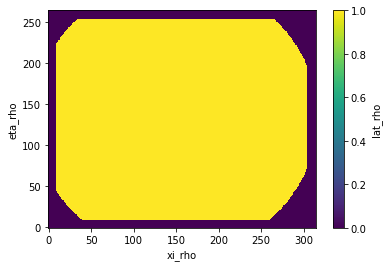

In [21]:
mask = (grd.lat_rho<-60)
mask[:100,:]=False
mask[-101:]=False
mask[:,:100]=False
mask[:,-101:]=False
mask[::10,::10].plot()

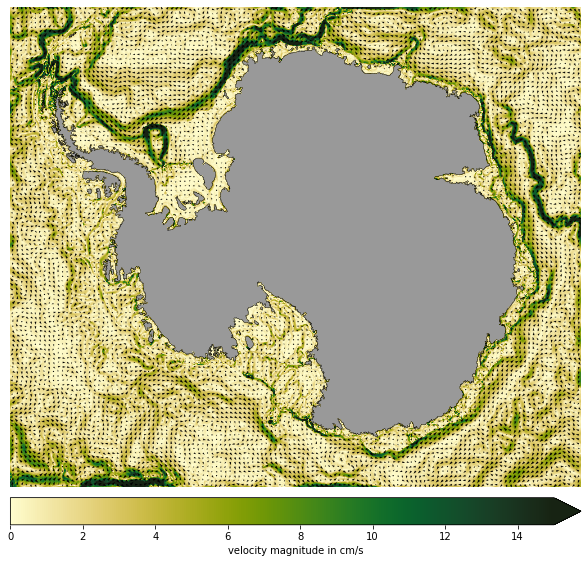

In [24]:
plot_uv_map(uv_mag*100,ubar*100,vbar*100,'2d_currents','velocity magnitude in cm/s',
            ocm.speed,[0,15],25,sel={'xi_rho':slice(None),'eta_rho':slice(None)},save=True,
            cb_ext='max')

# SSH ACC fronts

In [338]:
aviso_path = os.path.join(data_dir,'external','aviso','zos_AVISO_L4_199210-201012.nc')
aviso = xr.open_dataset(aviso_path).zos.sel(time='2007').mean('time').sel(lat=slice(-75,-40))

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [107]:
ecco_path = os.path.join(proj_dir,'data','preprocessing','external','ecco2','SSH.nc','SSH.1440x720.2007_monmean.nc')
ecco = xr.open_dataset(ecco_path).SSH.sel(LATITUDE_T=slice(-75,-40)).mean('TIME')

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [351]:
grd_path = os.path.join(int_dir,'grd10_dV.nc')
grd = xr.open_dataset(grd_path)
mask_vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)
grd.mask_rho.values[mask_vostock]=0

avg = xr.open_dataset(os.path.join(data_dir,'raw','waom10','ocean_avg_0009.nc'))

zeta = avg.zeta.mean('ocean_time')
#zeta = xr.open_dataset(os.path.join(data_dir,'raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')).zeta.mean('ocean_time')

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [369]:
import xesmf as xe
zeta = zeta.assign_coords({'lat':grd.lat_rho,'lon':grd.lon_rho})
grd_out = xe.util.grid_2d(-180,180,0.5,-80,-40,0.5)
regridder = xe.Regridder(zeta,grd_out,'bilinear')
zeta_out = regridder(zeta)

Overwrite existing file: bilinear_530x630_80x720.nc 
 You can set reuse_weights=True to save computing time.


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


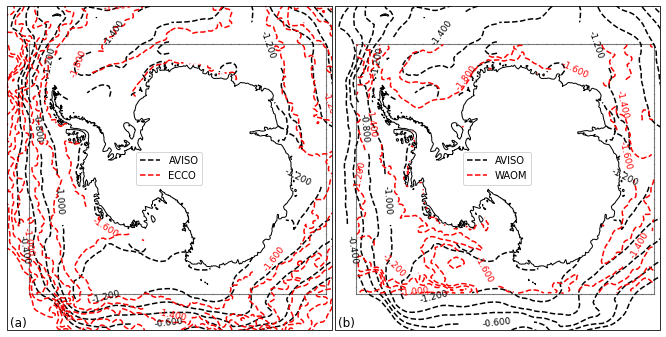

In [415]:
%matplotlib inline
lon_roms = grd.lon_rho.copy()
lon_roms.values[lon_roms<0]+=360

import cartopy.crs as ccrs
import string
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig = plt.figure(figsize = (11.69, 8.27))
levs = np.arange(-2,-0.25,.2)

ax1 = fig.add_subplot(121, projection = ccrs.SouthPolarStereo())
CA = aviso_2007.plot.contour(ax=ax1,levels=levs,colors='k',transform = ccrs.PlateCarree())
ax1.clabel(CA, fontsize=9, inline=1)
CE = ecco.plot.contour(ax=ax1,levels=levs,colors='r',transform = ccrs.PlateCarree())
ax1.clabel(CE, fontsize=9, inline=1)

legend_elements = [Line2D([0], [0], color='k',ls='dashed', label='AVISO'),
                   Line2D([0], [0], color='r',ls='dashed', label='ECCO')]
ax1.legend(handles=legend_elements, loc='center')


ax2 = fig.add_subplot(122, projection = ccrs.SouthPolarStereo())
CA = aviso_2007.plot.contour(ax=ax2,levels=levs,colors='k',transform = ccrs.PlateCarree())
ax2.clabel(CA, fontsize=9, inline=1)
CR = zeta_out.where(zeta_out).plot.contour(ax=ax2,levels=levs,transform = ccrs.PlateCarree(),x='lon',y='lat',
                                           colors='r',label='WAOM')
ax2.clabel(CR, fontsize=9, inline=1)

legend_elements = [Line2D([0], [0], color='k',ls='dashed', label='AVISO'),
                   Line2D([0], [0], color='r',ls='dashed', label='WAOM')]
ax2.legend(handles=legend_elements, loc='center')

n=0
for ax in [ax1,ax2]:
    ax.set_extent([-180, 180, -80, -59], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.scatter(lon_roms[:,0],grd.lat_rho[:,0],s=0.01,color='k',transform = ccrs.PlateCarree())
    ax.scatter(lon_roms[0,:],grd.lat_rho[0,:],s=0.01,color='k',transform = ccrs.PlateCarree())
    ax.scatter(lon_roms[:,-1],grd.lat_rho[:,-1],s=0.01,color='k',transform = ccrs.PlateCarree())
    ax.scatter(lon_roms[-1,:],grd.lat_rho[-1,:],s=0.01,color='k',transform = ccrs.PlateCarree())
    
    ax.text(0.01, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1

#pc = zeta_out.where(zeta_out).plot(ax=ax,vmin=-2,vmax=-0.25,cmap=ocm.deep,
#                                   cbar_kwargs={'label': 'Sea surfae height in m'},
#                              transform = ccrs.PlateCarree(),x='lon',y='lat')

#CR = zeta_out.where(zeta_out).plot.contour(ax=ax,levels=levs,transform = ccrs.PlateCarree(),x='lon',y='lat',colors='k')
#ax.clabel(CR, fontsize=9, inline=1)

plt.subplots_adjust(wspace=0.01)

#out_path = os.path.join(fig_dir,'ssh_aviso_ecco_waom.png')
#fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
#plt.show()

In [352]:
def calc_grad(lons,lats,val):
    #lons, lats = np.meshgrid(lon_1D,lat_1D)
    
    dx,dy = calc_dx_dy(lons,lats,'WGS84')
    dx = dx/100000
    dy = dy/100000
    field = val
    gradient = np.empty([field.shape[0],field.shape[1]])
    for y in np.arange(0, field.shape[0]):
        for x in np.arange(0, field.shape[1]):
            dy_point = dy[y,x]
            dx_point = dx[y,x]
            grad = np.gradient(field, dy_point, dx_point)            
            ddy_thta, ddx_thta = grad[-2:]
            mag_thta = np.sqrt(ddx_thta**2 + ddy_thta**2)
            gradient[y,x] = mag_thta[y,x]
            
    return gradient

def calc_dx_dy(longitude,latitude,shape,radius=6370997.):
    ''' This definition calculates the distance 
        between grid points that are in
        a latitude/longitude format.
        
        Using pyproj GEOD; different Earth Shapes 
        https://jswhit.github.io/pyproj/pyproj.Geod-class.html
        Common shapes: 'sphere', 'WGS84', 'GRS80'
        
        Accepts, 1D arrays for latitude and longitude
        
        Returns: dx, dy; 2D arrays of distances 
                       between grid points in the x and y direction in meters 
    '''
    from pyproj import Geod
    
    if (radius != 6370997.):
        g = Geod(a=radius,b=radius)
    else:
        g = Geod(ellps=shape)
    
    dx = np.empty(latitude.shape)
    dy = np.zeros(longitude.shape)
    
    for i in range(latitude.shape[1]):
        for j in range(latitude.shape[0]-1):
            _, _, dx[j,i] = g.inv(longitude[j,i],latitude[j,i],longitude[j+1,i],latitude[j+1,i])
    dx[j+1,:] = dx[j,:]
    
    for i in range(latitude.shape[1]-1):
        for j in range(latitude.shape[0]):
            _, _, dy[j,i] = g.inv(longitude[j,i],latitude[j,i],longitude[j,i+1],latitude[j,i+1])
    dy[:,i+1] = dy[:,i]
    
    return dx, dy

In [353]:
aviso_grad = aviso.copy()
lons, lats = np.meshgrid(aviso.lon.values,aviso.lat.values)
aviso_grad.values = calc_grad(lons,lats,aviso.values)

In [ ]:
zeta_grad = zeta.copy()
zeta_grad.values = calc_grad(grd.lon_rho.values,grd.lat_rho.values,zeta.values)
zeta_grad.to_netcdf(os.path.join(int_dir,'zeta_grad.nc'))

In [383]:
import xesmf as xe
lons = grd.lon_rho.copy()
lons.values[lons<0]+=360
zeta_grad = zeta_grad.assign_coords({'lat':grd.lat_rho,'lon':lons})
grd_out = xe.util.grid_2d(0.0,360,1,-75,-40,1)
regridder = xe.Regridder(zeta_grad,grd_out,'bilinear')
zeta_grad_out = regridder(zeta_grad)

Overwrite existing file: bilinear_530x630_35x360.nc 
 You can set reuse_weights=True to save computing time.


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


In [359]:
ecco = ecco.assign_coords({'lat':ecco.LATITUDE_T,'lon':ecco.LONGITUDE_T})
regridder = xe.Regridder(ecco,grd_out,'bilinear')
ecco_out = regridder(ecco)

ecco_grad = ecco_out.copy()
ecco_grad.values = calc_grad(ecco_grad.lon.values,ecco_grad.lat.values,ecco_grad.values)

Overwrite existing file: bilinear_140x1440_35x360.nc 
 You can set reuse_weights=True to save computing time.


/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/ESMF/interface/cbindings.py:2095: DeprecationWarning: Call to deprecated function ESMP_FieldRegridStoreFile.
  def ESMP_FieldRegridStoreFile(srcField, dstField, filename,


In [384]:
grads = xr.Dataset({'aviso':(['lat','lon'],aviso_grad),
                   'ecco':(['lat','lon'],ecco_grad),
                   'waom':(['lat','lon'],zeta_grad_out)},
                    coords={
                       "lon": (["lon"], aviso_grad.lon),
                        "lat": (["lat"], aviso_grad.lat),
                    })

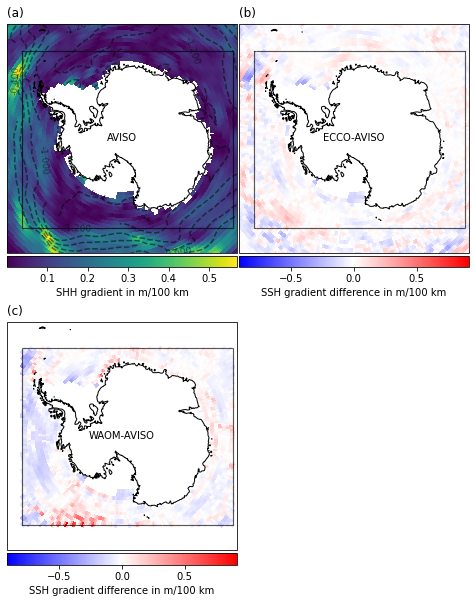

In [414]:
%matplotlib inline
lon_roms = grd.lon_rho.copy()
lon_roms.values[lon_roms<0]+=360

diff = grads.waom-grads.aviso
vmax = max(diff.max(),-diff.min())
vmin = -vmax

import cartopy.crs as ccrs
import string
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig = plt.figure(figsize = (8.27, 10.69))
levs = np.arange(-2,-0.25,.2)

ax1 = fig.add_subplot(221, projection = ccrs.SouthPolarStereo())
grads.aviso.plot(ax=ax1,transform = ccrs.PlateCarree(),cbar_kwargs={'label': 'SHH gradient in m/100 km','orientation':'horizontal','pad':0.01})
CA = aviso.plot.contour(ax=ax1,levels=levs,transform = ccrs.PlateCarree(),colors='k',alpha=0.5)
ax1.clabel(CA, fontsize=9, inline=1)
ax1.text(0.5, 0.5, 'AVISO', horizontalalignment='center',
      verticalalignment='center', transform=ax1.transAxes)

ax2 = fig.add_subplot(222, projection = ccrs.SouthPolarStereo())
(grads.ecco-grads.aviso).plot(ax=ax2,transform = ccrs.PlateCarree(),
                              cbar_kwargs={'label': 'SSH gradient difference in m/100 km','orientation':'horizontal','pad':0.01},
                             vmin=vmin,vmax=vmax,cmap='bwr')
ax2.text(0.5, 0.5, 'ECCO-AVISO', horizontalalignment='center',
      verticalalignment='center', transform=ax2.transAxes)

ax3 = fig.add_subplot(223, projection = ccrs.SouthPolarStereo())
(grads.waom-grads.aviso).where(grads.waom!=-0).plot(ax=ax3,transform = ccrs.PlateCarree(),
                                                    cbar_kwargs={'label': 'SSH gradient difference in m/100 km','orientation':'horizontal','pad':0.01},
                                                   vmin=vmin,vmax=vmax,cmap='bwr')
ax3.text(0.5, 0.5, 'WAOM-AVISO', horizontalalignment='center',
      verticalalignment='center', transform=ax3.transAxes)

n=0
for ax in [ax1,ax2,ax3]:
    ax.set_extent([-180, 180, -80, -59], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.scatter(lon_roms[:,0],grd.lat_rho[:,0],s=0.01,color='k',transform = ccrs.PlateCarree())
    ax.scatter(lon_roms[0,:],grd.lat_rho[0,:],s=0.01,color='k',transform = ccrs.PlateCarree())
    ax.scatter(lon_roms[:,-1],grd.lat_rho[:,-1],s=0.01,color='k',transform = ccrs.PlateCarree())
    ax.scatter(lon_roms[-1,:],grd.lat_rho[-1,:],s=0.01,color='k',transform = ccrs.PlateCarree())
    
    ax.text(-0.00, 1.03, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1    
#pc = zeta_out.where(zeta_out).plot(ax=ax,vmin=-2,vmax=-0.25,cmap=ocm.deep,
#                                   cbar_kwargs={'label': 'Sea surfae height in m'},
#                              transform = ccrs.PlateCarree(),x='lon',y='lat')

#CR = zeta_out.where(zeta_out).plot.contour(ax=ax,levels=levs,transform = ccrs.PlateCarree(),x='lon',y='lat',colors='k')
#ax.clabel(CR, fontsize=9, inline=1)

plt.subplots_adjust(wspace=0.01,hspace=0.05)

out_path = os.path.join(fig_dir,'grad_ssh_aviso_ecco_waom.png')
fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
plt.show()

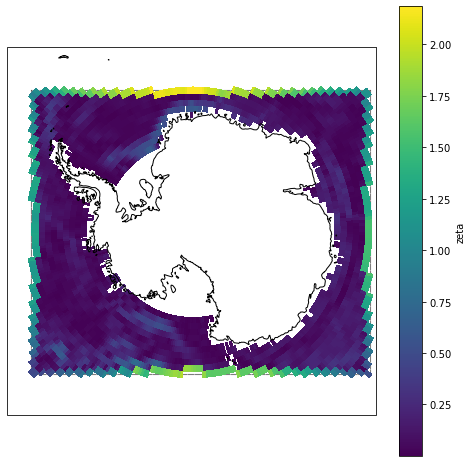

In [275]:
fig = plt.figure(figsize = (8.27, 8.27))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
                     #,proj_kw={'llcrnrlon':-130, 'urcrnrlon':51, 'llcrnrlat':-54, 'urcrnrlat':-52})
ax.set_extent([-180, 180, -80, -59], crs=ccrs.PlateCarree())
ax.coastlines()

ax.scatter(lon_roms[:,0],grd.lat_rho[:,0],s=0.01,color='k',transform = ccrs.PlateCarree())
ax.scatter(lon_roms[0,:],grd.lat_rho[0,:],s=0.01,color='k',transform = ccrs.PlateCarree())
ax.scatter(lon_roms[:,-1],grd.lat_rho[:,-1],s=0.01,color='k',transform = ccrs.PlateCarree())
ax.scatter(lon_roms[-1,:],grd.lat_rho[-1,:],s=0.01,color='k',transform = ccrs.PlateCarree())

pc = zeta_out_grad.where(zeta_out)[:].plot(ax=ax,transform = ccrs.PlateCarree(),x='lon',y='lat')#,vmin=-2,vmax=-0.25,cmap=ocm.deep,
#                                    cbar_kwargs={'label': 'Sea surfae height in m'},
#                               transform = ccrs.PlateCarree(),x='lon',y='lat')





#plt.tight_layout
#out_path = os.path.join(fig_dir,'ssh_vs_aviso.png')
#fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
plt.show()

/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/home/ubuntu/bigStick/anaconda3/envs/xesmf_env/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: The following kwargs were not used by contour: 'label'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


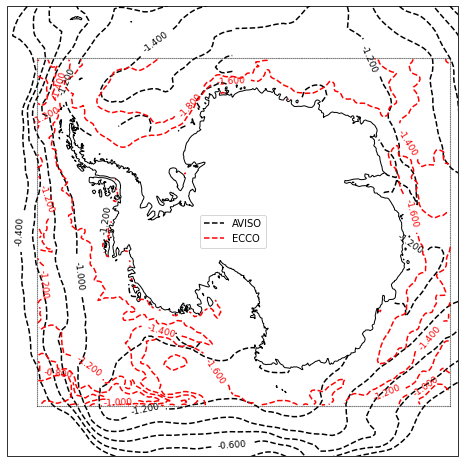

In [161]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import cartopy.crs as ccrs


lon_roms = grd.lon_rho.copy()
lon_roms.values[lon_roms<0]+=360







fig = plt.figure(figsize = (8.27, 8.27))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
                     #,proj_kw={'llcrnrlon':-130, 'urcrnrlon':51, 'llcrnrlat':-54, 'urcrnrlat':-52})
ax.set_extent([-180, 180, -80, -59], crs=ccrs.PlateCarree())
ax.coastlines()

levs = np.arange(-2,-0.25,.2)
CA = aviso_2007.plot.contour(ax=ax,levels=levs,colors='k',transform = ccrs.PlateCarree(),label='AVISO')
ax.clabel(CA, fontsize=9, inline=1)

#CE = ecco.plot.contour(ax=ax,levels=levs,colors='r',alpha=0.5,transform = ccrs.PlateCarree())
#ax.clabel(CE, fontsize=9, inline=1)

ax.scatter(lon_roms[:,0],grd.lat_rho[:,0],s=0.01,color='k',transform = ccrs.PlateCarree())
ax.scatter(lon_roms[0,:],grd.lat_rho[0,:],s=0.01,color='k',transform = ccrs.PlateCarree())
ax.scatter(lon_roms[:,-1],grd.lat_rho[:,-1],s=0.01,color='k',transform = ccrs.PlateCarree())
ax.scatter(lon_roms[-1,:],grd.lat_rho[-1,:],s=0.01,color='k',transform = ccrs.PlateCarree())

#pc = zeta_out.where(zeta_out).plot(ax=ax,vmin=-2,vmax=-0.25,cmap=ocm.deep,
#                                   cbar_kwargs={'label': 'Sea surfae height in m'},
#                              transform = ccrs.PlateCarree(),x='lon',y='lat')

CR = zeta_out.where(zeta_out).plot.contour(ax=ax,levels=levs,transform = ccrs.PlateCarree(),x='lon',y='lat',
                                           colors='r',label='WAOM')
ax.clabel(CR, fontsize=9, inline=1)



#plt.tight_layout
#out_path = os.path.join(fig_dir,'ssh_vs_aviso.png')
#fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
plt.show()

In [276]:
zeta_out_grad.where(zeta_out)[:-10]

<xarray.DataArray 'zeta' (y: 25, x: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lon      (y, x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lat      (y, x) float64 -74.5 -74.5 -74.5 -74.5 ... -50.5 -50.5 -50.5 -50.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [262]:
ecco_grad

<xarray.DataArray 'SSH' (y: 35, x: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.12379407, 0.08238325, 0.04153444, ..., 0.0715193 , 0.10615854,
        0.12313679],
       [0.01199332, 0.01208932, 0.00888911, ..., 0.03342659, 0.02791777,
        0.01866908],
       [0.01034726, 0.00460296, 0.03192495, ..., 0.03599932, 0.01913799,
        0.00802589]])
Coordinates:
    lon      (y, x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lat      (y, x) float64 -74.5 -74.5 -74.5 -74.5 ... -40.5 -40.5 -40.5 -40.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

In [256]:
zeta_out_grad

<xarray.DataArray 'zeta' (y: 35, x: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
    lon      (y, x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lat      (y, x) float64 -74.5 -74.5 -74.5 -74.5 ... -40.5 -40.5 -40.5 -40.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

MemoryError: Unable to allocate 5.41 GiB for an array with shape (80, 720, 35, 360) and data type float64

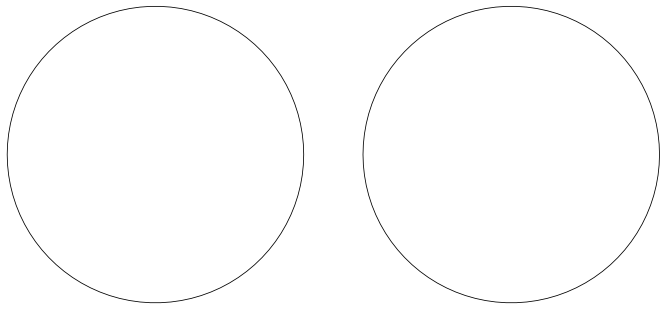

In [211]:
%matplotlib inline
lon_roms = grd.lon_rho.copy()
lon_roms.values[lon_roms<0]+=360

import cartopy.crs as ccrs
import string
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig = plt.figure(figsize = (11.69, 8.27))
levs = np.arange(-2,-0.25,.2)

ax1 = fig.add_subplot(121, projection = ccrs.SouthPolarStereo())

p = aviso_grad.plot(ax=ax,transform = ccrs.PlateCarree())
CA = aviso.plot.contour(ax=ax,levels=levs,colors='k',transform = ccrs.PlateCarree())
ax1.clabel(CA, fontsize=9, inline=1)

ax2 = fig.add_subplot(122, projection = ccrs.SouthPolarStereo())
CE = (ecco_grad-aviso_grad).plot(ax=ax2,transform = ccrs.PlateCarree())

n=0
for ax in [ax1,ax2]:
    ax.set_extent([-180, 180, -80, -59], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.scatter(lon_roms[:,0],grd.lat_rho[:,0],s=0.01,color='k',transform = ccrs.PlateCarree())
    ax.scatter(lon_roms[0,:],grd.lat_rho[0,:],s=0.01,color='k',transform = ccrs.PlateCarree())
    ax.scatter(lon_roms[:,-1],grd.lat_rho[:,-1],s=0.01,color='k',transform = ccrs.PlateCarree())
    ax.scatter(lon_roms[-1,:],grd.lat_rho[-1,:],s=0.01,color='k',transform = ccrs.PlateCarree())
    
    ax.text(0.01, 0.01, "("+string.ascii_lowercase[n]+")", transform=ax.transAxes, 
            size=12)
    n+=1

#pc = zeta_out.where(zeta_out).plot(ax=ax,vmin=-2,vmax=-0.25,cmap=ocm.deep,
#                                   cbar_kwargs={'label': 'Sea surfae height in m'},
#                              transform = ccrs.PlateCarree(),x='lon',y='lat')

#CR = zeta_out.where(zeta_out).plot.contour(ax=ax,levels=levs,transform = ccrs.PlateCarree(),x='lon',y='lat',colors='k')
#ax.clabel(CR, fontsize=9, inline=1)

plt.subplots_adjust(wspace=0.01)

#out_path = os.path.join(fig_dir,'ssh_aviso_ecco_waom.png')
#fig.savefig(out_path,format='png',dpi=400,bbox_inches = "tight")
#plt.show()

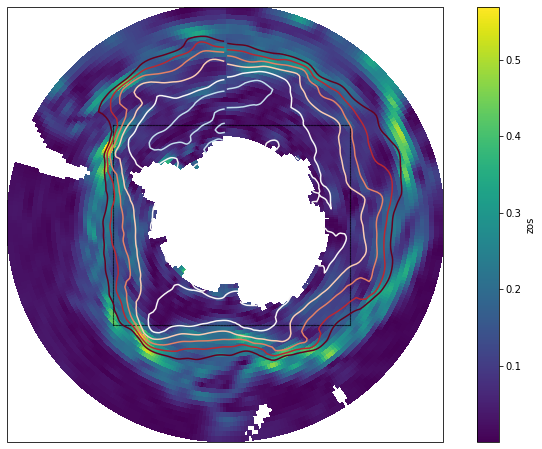

In [202]:
import cartopy.crs as ccrs
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
                     #,proj_kw={'llcrnrlon':-130, 'urcrnrlon':51, 'llcrnrlat':-54, 'urcrnrlat':-52})
ax.set_extent([-180, 180, -80, -40], crs=ccrs.PlateCarree())

p = aviso_grad.plot(ax=ax,transform = ccrs.PlateCarree())
aviso.plot.contour(ax=ax,levels=levs,transform = ccrs.PlateCarree())
ax.scatter(lon_roms[:,0],grd.lat_rho[:,0],s=0.01,color='k',transform = ccrs.PlateCarree())
ax.scatter(lon_roms[0,:],grd.lat_rho[0,:],s=0.01,color='k',transform = ccrs.PlateCarree())
ax.scatter(lon_roms[:,-1],grd.lat_rho[:,-1],s=0.01,color='k',transform = ccrs.PlateCarree())
ax.scatter(lon_roms[-1,:],grd.lat_rho[-1,:],s=0.01,color='k',transform = ccrs.PlateCarree())

plt.show()

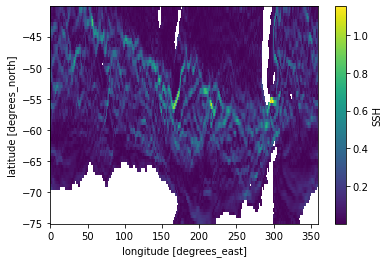

In [204]:
ecco_grad.plot()

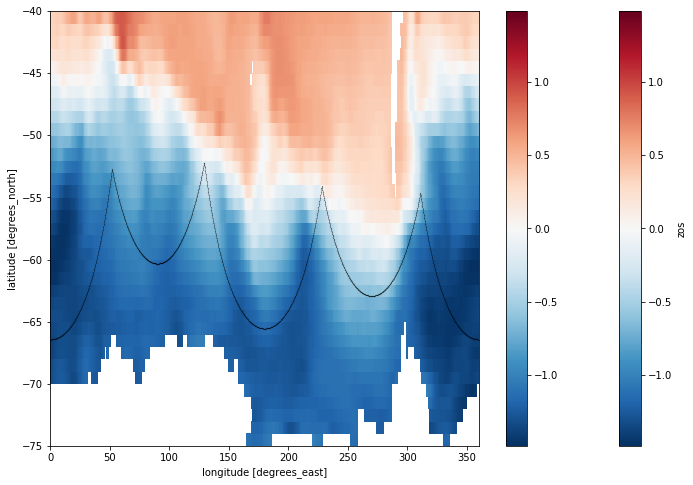

In [117]:
lon_roms = grd.lon_rho.copy()
lon_roms.values[lon_roms<0]+=360

fig,ax = plt.subplots(figsize = (12, 8))
p = aviso_2007.plot(ax=ax)
plt.colorbar(p,ax=ax)
plt.scatter(lon_roms[:,0],grd.lat_rho[:,0],s=0.01,color='k')
plt.scatter(lon_roms[0,:],grd.lat_rho[0,:],s=0.01,color='k')
plt.scatter(lon_roms[:,-1],grd.lat_rho[:,-1],s=0.01,color='k')
plt.scatter(lon_roms[-1,:],grd.lat_rho[-1,:],s=0.01,color='k')

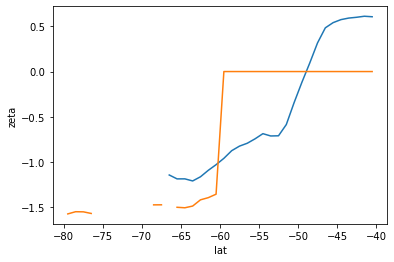

In [44]:
aviso_2007[:,115].plot()
zeta_out[:,115].plot(x='lat')

In [120]:
plt.contour?

In [36]:
lons, lats = np.meshgrid(zeta_out.lon.values,zeta_out.lat.values)
dx,dy = new_calc_dx_dy(lons,lats,'WGS84')
dx = dx/100000
dy = dy/100000
field = zeta_out.values
gradient = np.empty([field.shape[0],field.shape[1]])
for y in np.arange(0, field.shape[0]):
    for x in np.arange(0, field.shape[1]):
        dy_point = dy[y,x]
        dx_point = dx[y,x]
        grad = np.gradient(field, dy_point, dx_point)            
        ddy_thta, ddx_thta = grad[-2:]
        mag_thta = np.sqrt(ddx_thta**2 + ddy_thta**2)
        gradient[y,x] = mag_thta[y,x]

KeyboardInterrupt: 

In [31]:
zeta_out_grd = zeta_out.copy()
zeta_out_grad.values = gradient

<xarray.DataArray 'zeta' (y: 40, x: 360)>
array([[-1.46522426, -1.47061141, -1.47420822, ..., -1.46730663,
        -1.46417646, -1.46285254],
       [-1.44396998, -1.45207797, -1.45405776, ..., -1.45819876,
        -1.45849475, -1.44551286],
       [-1.42685849, -1.42198673, -1.41967741, ..., -1.44176641,
        -1.44004856, -1.43587979],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -79.5 -79.5 -79.5 -79.5 ... -40.5 -40.5 -40.5 -40.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear

# isopycnal depth

In [15]:
# Generate ROMS and SOSE Xarray datasets
import xarray as xr
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as ocm

proj_dir = os.path.join(os.pardir,os.pardir)
fig_dir = os.path.join(proj_dir,'reports','devel','figures')
data_dir = os.path.join(proj_dir,'data')
src_path = os.path.join(os.environ.get('projdir'),'src')

import tools2.make_sose_ds as sose_ds
%load_ext autoreload

%autoreload 1
%aimport tools2.make_sose_ds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import xarray as xr
import numpy as np
from tools2.calc_z import calc_z
from tools2.cartesian_grid_3d import cartesian_grid_3d
from tools2.rotate_vector_roms import rotate_vector_roms
import gsw


def make_3D_XiEta(ds,grd):
    
    xi_3d = np.tile(grd.xi_rho,(31,grd.eta_rho.size,1))
    eta_3d = np.swapaxes(np.tile(grd.eta_rho,(31,grd.xi_rho.size,1)),1,2)
    
    xi_3d = xr.DataArray(xi_3d,dims=['s_rho','eta_rho','xi_rho'])
    eta_3d = xr.DataArray(eta_3d,dims=['s_rho','eta_rho','xi_rho'])
    
    #ds = ds.assign_coords(xi_3d=xi_3d_da)
    #ds = ds.assign_coords(eta_3d=eta_3d_da)
    
    #ds.xi_3d.attrs = grd.xi_rho.attrs
    #ds.eta_3d.attrs = grd.eta_rho.attrs
    
    return xi_3d,eta_3d



def make_3D_depth(ds,grd,zeta):

    h = grd.h.values
    zice = grd.zice.values
    theta_s = 7
    theta_b = 8
    hc = 250
    N = 31
    Vstretching = 4    
    zeta = zeta.values
        
    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)
        
    depth_3d =    xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']) 
    #ds = ds.assign_coords(depth = xr.DataArray(depths,dims=['ocean_time','s_rho','eta_rho','xi_rho']))
    
    return depth_3d

def make_3D_density(grd,ds):

    rho = np.empty((31,grd.eta_rho.size,grd.xi_rho.size))
    
    p = gsw.conversions.p_from_z(ds.depth,grd.lat_rho)
    SA = gsw.conversions.SA_from_SP(ds.salt,p,grd.lon_rho,grd.lat_rho)
    CT = gsw.conversions.CT_from_pt(SA,ds.temp)
    rho=gsw.density.rho(SA,CT,p)

    

    return xr.DataArray(rho,dims=['s_rho','eta_rho','xi_rho'])

In [165]:
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp_avg.nc')
salt_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_salt_avg.nc')
zeta_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_zeta_avg.nc')
temp = xr.open_dataset(temp_path).temp.isel(ocean_time=0)
salt = xr.open_dataset(salt_path).salt.isel(ocean_time=0)
zeta = xr.open_dataset(zeta_path).zeta.isel(ocean_time=0)

grd_path = os.path.join(data_dir,'analysis','interim','grd2_dV.nc')
grd = xr.open_dataset(grd_path)

In [20]:
avg = xr.open_dataset(os.path.join(data_dir,'analysis','raw','waom10','ocean_avg_0009.nc'))
temp = avg.temp.mean('ocean_time')
salt = avg.salt.mean('ocean_time')
zeta = avg.zeta.mean('ocean_time')

grd_path = os.path.join(data_dir,'analysis','interim','grd10_dV.nc')
grd = xr.open_dataset(grd_path)

In [25]:
xi_3d,eta_3d = make_3D_XiEta(temp,grd)
depth_3d = make_3D_depth(temp,grd,zeta)
rds = grd.copy()
rds['temp'] = temp
rds['salt'] = salt
rds = rds.assign_coords(xi_3d=xi_3d)
rds = rds.assign_coords(eta_3d=eta_3d)
rds = rds.assign_coords(depth = depth_3d)

rds = rds.assign_coords(lat_rho = grd.lat_rho)
rds = rds.assign_coords(lon_rho = grd.lon_rho)

In [5]:
sose_path = os.path.join(data_dir,'preprocessing','external','sose')
sds = sose_ds.make_TS_ds(sose_dir=sose_path,records=np.arange(0,12))
sds = sds.mean('time')

load grid
load temperature


/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


load salt
construct Xarray dataset
done!


In [102]:
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as ocm
import matplotlib

title = 'Ross Sea at Longitude -145 deg W'
lon = -145
lats = np.arange(-77,-55,0.25)
sel={'xi_rho':slice(100,300),'eta_rho':slice(0,200)}

if lon < 0.0:
    slon = lon + 360.0
    rlon = lon
elif lon > 180:
    slon = lon
    rlon = lon - 360.0
else:
    slon = lon
    rlon = lon

rds= rds.isel(sel)

In [103]:
rtemp_flat = rds.temp.stack(xieta=('xi_rho','eta_rho'))
rsalt_flat = rds.salt.stack(xieta=('xi_rho','eta_rho')) 
points = np.column_stack((rtemp_flat.lat_rho.values,rtemp_flat.lon_rho.values))
tree = KDTree(points)

lats_t = sds.sel(longitude=slon,latitude=lats,method='nearest').latitude.values
lons_t = np.full(np.shape(lats_t),rlon,dtype=int)
#lats_t = np.linspace(lats.min(),lats.max(),size)
#lons_t = np.repeat(lon,size)
target = np.column_stack((lats_t,lons_t))
dist, ind = tree.query(target)

rtemp_tr = rtemp_flat[:,ind]
rsalt_tr = rsalt_flat[:,ind]
rlat=rtemp_tr.lat_rho.fillna(0).values
rlon=rtemp_tr.lon_rho.fillna(0).values
rdepth=rtemp_tr.depth.fillna(0).values
rtemp_val=rtemp_tr.to_masked_array()
rsalt_val=rsalt_tr.to_masked_array()

p = gsw.conversions.p_from_z(rdepth,rlat)
SA = gsw.conversions.SA_from_SP(rsalt_val,p,rlon,rlat)
CT = gsw.conversions.CT_from_pt(SA,rtemp_val)
rrho=gsw.density.rho(SA,CT,p)

stemp = sds.temperature.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest')
ssalt = sds.salinity.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest')
slat,sdepth = np.meshgrid(stemp.latitude,stemp.depth)
p = gsw.conversions.p_from_z(sdepth,slat)
SA = gsw.conversions.SA_from_SP(ssalt,p,ssalt.longitude,slat)
CT = gsw.conversions.CT_from_pt(SA,stemp)
srho=gsw.density.rho(SA,CT,p)


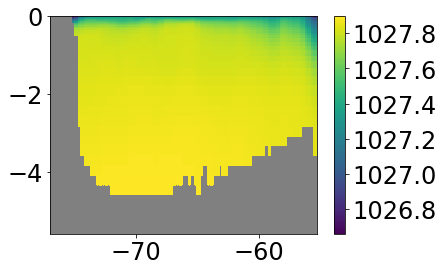

In [126]:
levs = np.arange(1026.8,1027.8)
plt.pcolormesh(stemp.latitude,stemp.depth,srho)
plt.colorbar()

In [134]:
np.random.uniform(-2, 2, 10)

array([ 0.57962705, -1.30198983, -1.27865407, -0.88737797, -0.76247728,
       -0.31842488, -1.09951504, -0.58964746,  0.72408682,  1.44832915])

In [122]:
rlat_2d,rdepth_2d = np.meshgrid(rlat,rdepth[:,0])

In [ ]:
import matplotlib.tri as tri
x = rlat_2d.flatten()
y = rdepth.flatten()
z = rrho.flatten()

triang = tri.Triangulation(x, y)

fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
tcf = ax1.tricontourf(triang, z)

/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1169: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1169: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/home/ubuntu/bigStick/anaconda3/envs/antarctic_melting/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


IndexError: index 2 is out of bounds for size 2

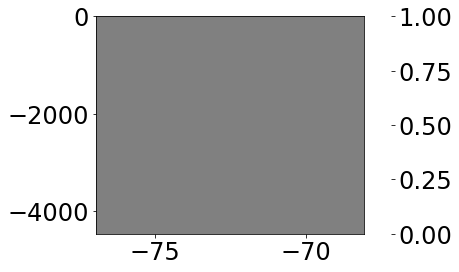

In [136]:
levs = np.arange(1026.8,1027.8)
plt.tricontour(x,y,z)
plt.colorbar()

In [ ]:
plt.close()
        
fig,axes = plt.subplots(nrows =2,figsize=(15,12))
matplotlib.rcParams.update({'font.size': 24})
plt.rcParams['axes.facecolor']='gray'
#plt.rcParams['savefig.facecolor']='gray'

(ax1,ax2) = axes.flatten()
ocm.dense.set_bad('gray')

plt.pcolormesh(stemp.latitude,stemp.depth,srho)
sds.temperature.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest').plot(ax=ax1,
                                x='latitude',y='depth',vmin=tmin,vmax=tmax,cmap=ocm.thermal,
                                add_colorbar=False)


sds.salinity.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest').plot(ax=ax3,
                                x='latitude',y='depth',vmin=smin,vmax=smax,cmap=ocm.haline,
                                add_colorbar=False)

ax2.set_facecolor('gray')
temp_plt = ax2.pcolormesh(x,y,rtemp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
ax4.set_facecolor('gray')
salt_plt = ax4.pcolormesh(x,y,rsalt_val,vmin=smin,vmax=smax,cmap=ocm.haline)  

ax1.set_title('SOSE')
ax2.set_title('ROMS')
ax3.set_title('')

for ax in axes.flatten()[[0,1]]:
    ax.set_xticklabels('')
    ax.set_xlabel('')

for ax in axes.flatten()[[1,3]]:
    ax.set_yticklabels('')

for ax in axes.flatten()[2:]:
    ax.set_xlabel('Latitude in $^{\circ}$S',fontsize=24)
    ax.tick_params(axis='x', labelsize=24)
for ax in axes.flatten()[[0,2]]:
    #ax.ticklabel_format(axis="y",useOffset=-1000)
    ax.set_ylabel('Depth in km',fontsize=24)
    ax.tick_params(axis='y', labelsize=24)

fig.tight_layout(pad=0.15)

p0 = axes.flatten()[1].get_position().get_points().flatten()
ax_cbar_upper = fig.add_axes([1, p0[1],0.02,p0[3]-p0[1]])
cbar_upper = plt.colorbar(temp_plt, cax=ax_cbar_upper)
cbar_upper.set_label('Temperature in $^{\circ}$C',weight = 'bold',size=24)
cbar_upper.ax.tick_params(labelsize=24)

p1 = axes.flatten()[3].get_position().get_points().flatten()
ax_cbar_lower = fig.add_axes([1, p1[1],0.02,p1[3]-p1[1]])
cbar_lower = plt.colorbar(salt_plt, cax=ax_cbar_lower)
cbar_lower.set_label('Salinity in psu',weight = 'bold',size=24)
cbar_lower.ax.tick_params(labelsize=24)

if max_depth != None:
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_ylim([-max_depth,0])
if save:
    plt.savefig(os.path.join(fig_dir,title.replace('/','_')+'ts_trans.png'),dpi=300,bbox_inches='tight')

plt.show()

In [60]:
p = gsw.conversions.p_from_z(rdepth,rlat)
SA = gsw.conversions.SA_from_SP(rsalt_val,p,rlon,rlat)
CT = gsw.conversions.CT_from_pt(SA,rtemp_val)
rho=gsw.density.rho(SA,CT,p)

In [75]:
rdepth[:,70]

array([-3422.79312124, -3407.08247174, -3376.28169801, -3317.34329324,
       -3217.10058326, -3067.49874437, -2868.92217974, -2630.02439334,
       -2364.82685121, -2088.95767271, -1816.57229872, -1558.60133467,
       -1322.24223844, -1111.28318244,  -926.82646328,  -768.09739583,
        -633.16339739,  -519.49398705,  -424.35604396,  -345.06877022,
        -279.15195766,  -224.39951878,  -178.90431638,  -141.05362893,
        -109.50869578,   -83.17719074,   -61.18415307,   -42.84463981,
         -27.63989421,   -15.19792235,    -5.27885166])

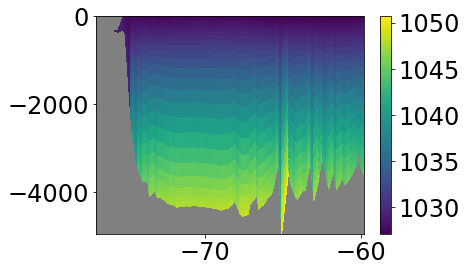

In [69]:
plt.pcolormesh(rlat,rdepth,rho)
plt.colorbar()

In [70]:
stemp = sds.temperature.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest')
ssalt = sds.salinity.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest')

In [97]:
slat,sdepth = np.meshgrid(stemp.latitude,stemp.depth)
p = gsw.conversions.p_from_z(sdepth,slat)
SA = gsw.conversions.SA_from_SP(ssalt,p,ssalt.longitude,slat)
CT = gsw.conversions.CT_from_pt(SA,stemp)
rho=gsw.density.rho(SA,CT,p)

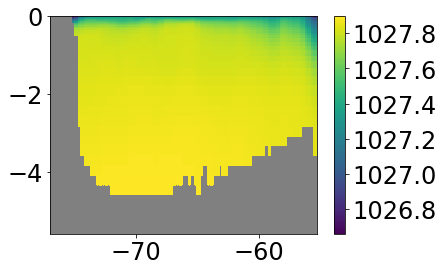

In [100]:
plt.pcolormesh(stemp.latitude,stemp.depth,rho)
plt.colorbar()

In [73]:
sdepth, slat = np.meshgrid(sdepth,slat)

p = gsw.conversions.p_from_z(stemp.depth,stemp.latitude)
SA = gsw.conversions.SA_from_SP(rsalt_val,p,rlon,rlat)
CT = gsw.conversions.CT_from_pt(SA,rtemp_val)
rho=gsw.density.rho(SA,CT,p)

ValueError: operands could not be broadcast together with shapes (42,) (88,) 

In [8]:
sds['depth'] = sds.depth*10**-3
rds['depth'] = rds.depth*10**-3

In [9]:
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as ocm
import matplotlib

def plot_lont(title,sds,rds,lon,lats,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,save=False,size=100,sel=False):
    
    if lon < 0.0:
        slon = lon + 360.0
        rlon = lon
    elif lon > 180:
        slon = lon
        rlon = lon - 360.0
    else:
        slon = lon
        rlon = lon
        
    rds= rds.isel(sel)
        
    print('lookup nearest neighbors from roms')
    rtemp_flat = rds.temp.stack(xieta=('xi_rho','eta_rho'))
    rsalt_flat = rds.salt.stack(xieta=('xi_rho','eta_rho')) 
    points = np.column_stack((rtemp_flat.lat_rho.values,rtemp_flat.lon_rho.values))
    tree = KDTree(points)
    
    print('lookup nearest neighbors from sose')
    lats_t = sds.sel(longitude=slon,latitude=lats,method='nearest').latitude.values
    lons_t = np.full(np.shape(lats_t),rlon,dtype=int)
    #lats_t = np.linspace(lats.min(),lats.max(),size)
    #lons_t = np.repeat(lon,size)
    target = np.column_stack((lats_t,lons_t))
    dist, ind = tree.query(target)
    
    print('define axes and values from roms')
    rtemp_tr = rtemp_flat[:,ind]
    rsalt_tr = rsalt_flat[:,ind]
    x=rtemp_tr.lat_rho.fillna(0).values
    y=rtemp_tr.depth.fillna(0).values
    rtemp_val=rtemp_tr.to_masked_array()
    rsalt_val=rsalt_tr.to_masked_array()
    
    print('plotting')
    plt.close()
        
    fig,axes = plt.subplots(2,2,figsize=(15,12))
    matplotlib.rcParams.update({'font.size': 24})
    plt.rcParams['axes.facecolor']='gray'
    #plt.rcParams['savefig.facecolor']='gray'

    (ax1,ax2,ax3,ax4) = axes.flatten()
    ocm.thermal.set_bad('gray')
    ocm.haline.set_bad('gray')

    
    sds.temperature.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest').plot(ax=ax1,
                                    x='latitude',y='depth',vmin=tmin,vmax=tmax,cmap=ocm.thermal,
                                    add_colorbar=False)
    
    
    sds.salinity.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest').plot(ax=ax3,
                                    x='latitude',y='depth',vmin=smin,vmax=smax,cmap=ocm.haline,
                                    add_colorbar=False)

    ax2.set_facecolor('gray')
    temp_plt = ax2.pcolormesh(x,y,rtemp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    ax4.set_facecolor('gray')
    salt_plt = ax4.pcolormesh(x,y,rsalt_val,vmin=smin,vmax=smax,cmap=ocm.haline)  
    
    ax1.set_title('SOSE')
    ax2.set_title('ROMS')
    ax3.set_title('')
    
    for ax in axes.flatten()[[0,1]]:
        ax.set_xticklabels('')
        ax.set_xlabel('')
    
    for ax in axes.flatten()[[1,3]]:
        ax.set_yticklabels('')

    for ax in axes.flatten()[2:]:
        ax.set_xlabel('Latitude in $^{\circ}$S',fontsize=24)
        ax.tick_params(axis='x', labelsize=24)
    for ax in axes.flatten()[[0,2]]:
        #ax.ticklabel_format(axis="y",useOffset=-1000)
        ax.set_ylabel('Depth in km',fontsize=24)
        ax.tick_params(axis='y', labelsize=24)
        
    fig.tight_layout(pad=0.15)

    p0 = axes.flatten()[1].get_position().get_points().flatten()
    ax_cbar_upper = fig.add_axes([1, p0[1],0.02,p0[3]-p0[1]])
    cbar_upper = plt.colorbar(temp_plt, cax=ax_cbar_upper)
    cbar_upper.set_label('Temperature in $^{\circ}$C',weight = 'bold',size=24)
    cbar_upper.ax.tick_params(labelsize=24)

    p1 = axes.flatten()[3].get_position().get_points().flatten()
    ax_cbar_lower = fig.add_axes([1, p1[1],0.02,p1[3]-p1[1]])
    cbar_lower = plt.colorbar(salt_plt, cax=ax_cbar_lower)
    cbar_lower.set_label('Salinity in psu',weight = 'bold',size=24)
    cbar_lower.ax.tick_params(labelsize=24)
    
    if max_depth != None:
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_ylim([-max_depth,0])
    if save:
        plt.savefig(os.path.join(fig_dir,title.replace('/','_')+'ts_trans.png'),dpi=300,bbox_inches='tight')

    plt.show()

lookup nearest neighbors from roms
lookup nearest neighbors from sose
define axes and values from roms
plotting


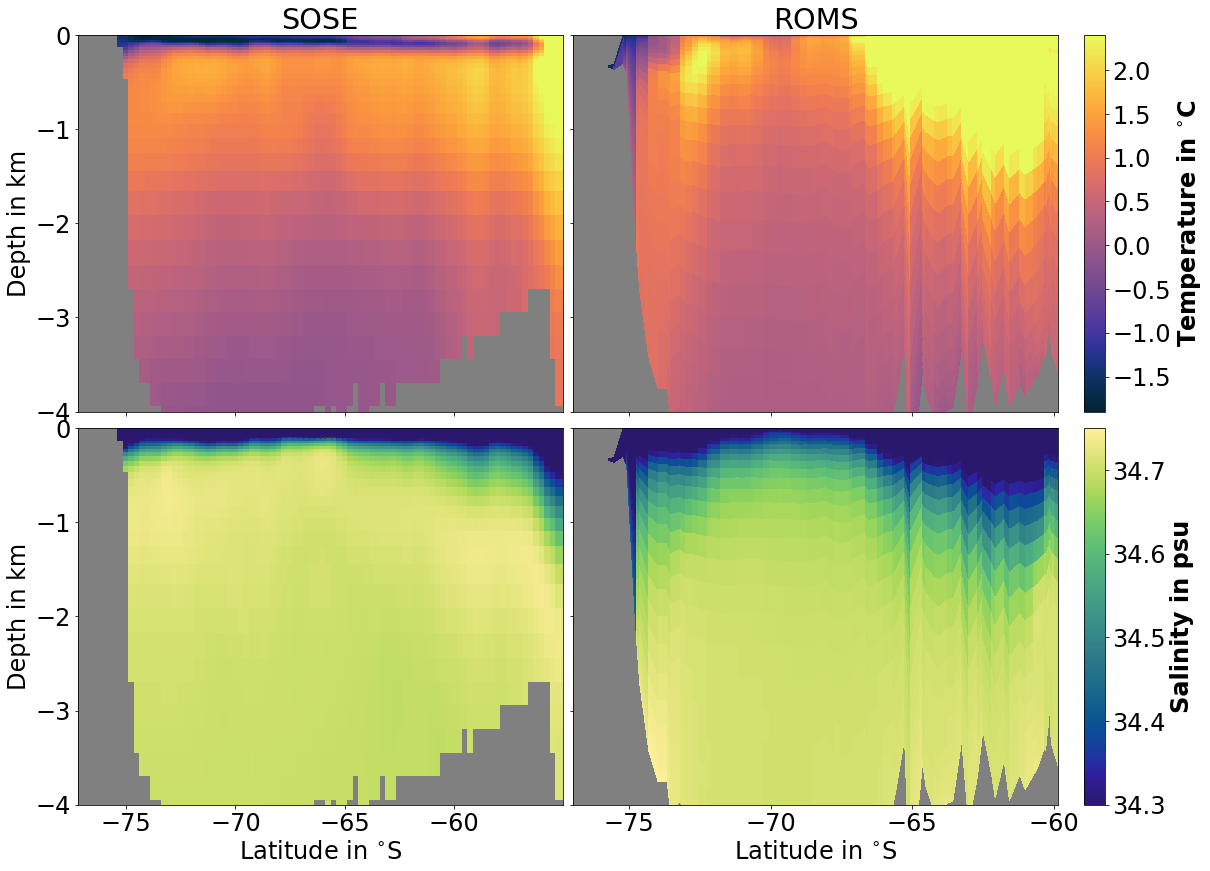

In [11]:
plot_lont('Ross Sea at Longitude -145 deg W',sds,rds,-145,np.arange(-77,-55,0.25),tmin=-1.9,tmax=2.4,smin=34.3,smax=34.75,max_depth=4,
          save=False,sel={'xi_rho':slice(100,300),'eta_rho':slice(0,200)})

In [ ]:
def plot_lont(title,sds,rds,lon,lats,max_depth=None,tmin=-3,tmax=1,smin=33.8,smax=34.8,save=False,size=100,sel=False):
    
    if lon < 0.0:
        slon = lon + 360.0
        rlon = lon
    elif lon > 180:
        slon = lon
        rlon = lon - 360.0
    else:
        slon = lon
        rlon = lon
        
    rds= rds.isel(sel)
        
    print('lookup nearest neighbors from roms')
    rtemp_flat = rds.temp.stack(xieta=('xi_rho','eta_rho'))
    rsalt_flat = rds.salt.stack(xieta=('xi_rho','eta_rho')) 
    points = np.column_stack((rtemp_flat.lat_rho.values,rtemp_flat.lon_rho.values))
    tree = KDTree(points)
    
    print('lookup nearest neighbors from sose')
    lats_t = sds.sel(longitude=slon,latitude=lats,method='nearest').latitude.values
    lons_t = np.full(np.shape(lats_t),rlon,dtype=int)
    #lats_t = np.linspace(lats.min(),lats.max(),size)
    #lons_t = np.repeat(lon,size)
    target = np.column_stack((lats_t,lons_t))
    dist, ind = tree.query(target)
    
    print('define axes and values from roms')
    rtemp_tr = rtemp_flat[:,ind]
    rsalt_tr = rsalt_flat[:,ind]
    x=rtemp_tr.lat_rho.fillna(0).values
    y=rtemp_tr.depth.fillna(0).values
    rtemp_val=rtemp_tr.to_masked_array()
    rsalt_val=rsalt_tr.to_masked_array()
    
    print('plotting')
    plt.close()
        
    fig,axes = plt.subplots(2,2,figsize=(15,12))
    matplotlib.rcParams.update({'font.size': 24})
    plt.rcParams['axes.facecolor']='gray'
    #plt.rcParams['savefig.facecolor']='gray'

    (ax1,ax2,ax3,ax4) = axes.flatten()
    ocm.thermal.set_bad('gray')
    ocm.haline.set_bad('gray')

    
    sds.temperature.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest').plot(ax=ax1,
                                    x='latitude',y='depth',vmin=tmin,vmax=tmax,cmap=ocm.thermal,
                                    add_colorbar=False)
    
    
    sds.salinity.where(sds.maskC).sel(longitude=slon,latitude=lats,method='nearest').plot(ax=ax3,
                                    x='latitude',y='depth',vmin=smin,vmax=smax,cmap=ocm.haline,
                                    add_colorbar=False)

    ax2.set_facecolor('gray')
    temp_plt = ax2.pcolormesh(x,y,rtemp_val,vmin=tmin,vmax=tmax,cmap=ocm.thermal)
    ax4.set_facecolor('gray')
    salt_plt = ax4.pcolormesh(x,y,rsalt_val,vmin=smin,vmax=smax,cmap=ocm.haline)  
    
    ax1.set_title('SOSE')
    ax2.set_title('ROMS')
    ax3.set_title('')
    
    for ax in axes.flatten()[[0,1]]:
        ax.set_xticklabels('')
        ax.set_xlabel('')
    
    for ax in axes.flatten()[[1,3]]:
        ax.set_yticklabels('')

    for ax in axes.flatten()[2:]:
        ax.set_xlabel('Latitude in $^{\circ}$S',fontsize=24)
        ax.tick_params(axis='x', labelsize=24)
    for ax in axes.flatten()[[0,2]]:
        #ax.ticklabel_format(axis="y",useOffset=-1000)
        ax.set_ylabel('Depth in km',fontsize=24)
        ax.tick_params(axis='y', labelsize=24)
        
    fig.tight_layout(pad=0.15)

    p0 = axes.flatten()[1].get_position().get_points().flatten()
    ax_cbar_upper = fig.add_axes([1, p0[1],0.02,p0[3]-p0[1]])
    cbar_upper = plt.colorbar(temp_plt, cax=ax_cbar_upper)
    cbar_upper.set_label('Temperature in $^{\circ}$C',weight = 'bold',size=24)
    cbar_upper.ax.tick_params(labelsize=24)

    p1 = axes.flatten()[3].get_position().get_points().flatten()
    ax_cbar_lower = fig.add_axes([1, p1[1],0.02,p1[3]-p1[1]])
    cbar_lower = plt.colorbar(salt_plt, cax=ax_cbar_lower)
    cbar_lower.set_label('Salinity in psu',weight = 'bold',size=24)
    cbar_lower.ax.tick_params(labelsize=24)
    
    if max_depth != None:
        for ax in [ax1,ax2,ax3,ax4]:
            ax.set_ylim([-max_depth,0])
    if save:
        plt.savefig(os.path.join(fig_dir,title.replace('/','_')+'ts_trans.png'),dpi=300,bbox_inches='tight')

    plt.show()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


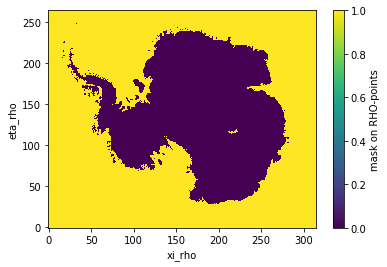

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [171]:
grd.mask_rho[::10,::10].plot()
grd.lat_rho[::10,::10].plot.contour()
plt.grid()

In [83]:
client.close()

In [84]:
grd_path = os.path.join(int_dir,'grd10_dV.nc')
grd = xr.open_dataset(grd_path)
mask_vostock = (grd.lat_rho<-75) & (grd.lat_rho>-80) & (grd.lon_rho>95) & (grd.lon_rho<115)
grd.mask_rho.values[mask_vostock]=0

avg = xr.open_dataset(os.path.join(data_dir,'raw','waom10','ocean_avg_0009.nc'))
temp = avg.temp.mean('ocean_time')

In [93]:
temp = temp.assign_coords(lon=grd.lon_rho)
temp = temp.assign_coords(lat=grd.lat_rho)

In [142]:
lat_bins = np.arange(-90,-65,0.5)
lat_center = np.arange(-89.75,-65.25,0.5)
lon_bins = np.arange(-180,180.5,0.5)

In [144]:
lat_center.size

49

In [145]:
lat_bins.size

50

In [146]:
grouped = temp.groupby_bins('lat',lat_bins,labels=lat_center).mean('stacked_eta_rho_xi_rho')

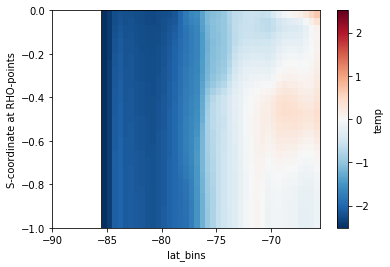

In [147]:
grouped.plot()

In [114]:
stacked = temp.stack(etaXi = ['eta_rho','xi_rho'])
stacked.groupby_bins('lon',lon_bins).mean()

<xarray.DataArray 'temp' (lon_bins: 720)>
array([-0.37011 , -0.318478, -0.37066 , ..., -0.33117 , -0.287429, -0.351935])
Coordinates:
  * lon_bins  (lon_bins) object (-180.0, -179.5] (-179.5, -179.0] ...